<a href="https://colab.research.google.com/github/peeyushsinghal/da_cv_fer/blob/main/da_cv_fer_sfew_expw_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cloning repository
Importing files regarding dataset, model, mains and utils

In [39]:
!git clone https://github.com/peeyushsinghal/da_cv_fer.git
import os
os.getcwd()
os.chdir('da_cv_fer')

Cloning into 'da_cv_fer'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 73 (delta 5), reused 0 (delta 0), pack-reused 57
Receiving objects: 100% (73/73), 2.15 MiB | 24.41 MiB/s, done.
Resolving deltas: 100% (31/31), done.


Installing dependencies

In [40]:
!pip install -q -r requirements.txt # -q is for quiet install
!pip install -q opendatasets # quient install, for some reason this does not get installed with requirements

ERROR: Could not find a version that satisfies the requirement pywin32==306 (from versions: none)
ERROR: No matching distribution found for pywin32==306


## Libraries and Initializations

In [41]:
# Installs from files
from da_cv_fer.data_config import DataConfig
from da_cv_fer.ds_sfew import DatasetSFEW
from da_cv_fer.ds_expw import EXPW
from da_cv_fer.utils import show_batch
from da_cv_fer.model_DANN import DANN
from da_cv_fer.run_config import RunConfig
from da_cv_fer.train import (weights_init,
                             train_model,
                             get_correct_predictions,
                             test_model)

import os
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm # for beautiful model training updates

import matplotlib.pyplot as plt # for plots

import time
from pathlib import Path

from copy import deepcopy
import numpy as np

### Initializing configs

In [42]:
#initializing dataconfig, it tells us about dataset configuration and directory structure
dataconfig = DataConfig()

## EXPW Dataset
Creating dataset and dataloader objects.
Split into train and val.

`details: da_cv_fer.ds_expw.EXPW`
<br>
Please be patient, it takes around 3 minutes to download data set

In [51]:
expw_obj = EXPW()
expw_train_ds, expw_val_ds = expw_obj.get_dataset()
expw_train_loader, expw_val_loader = expw_obj.get_dataloader()
print(f' length of EXPW dataset : {len(expw_train_loader.dataset)} , {len(expw_train_ds)}')

desitination file path = dataset/expwds/expwds.zip
in EXPW()...
Directory dataset/expwds created successfully.


100%|██████████| 7.68G/7.68G [06:17<00:00, 21.8MB/s]



File downloaded successfully from https://www.kaggle.com/datasets/mohammedaaltaha/expwds to dataset/expwds/expwds.zip
Unzipped Files already exist in dataset/expwds, not extracted
Directory dataset/expwds already exists.
Directory dataset/expwds already exists.
 length of EXPW dataset : 54476 , 54476


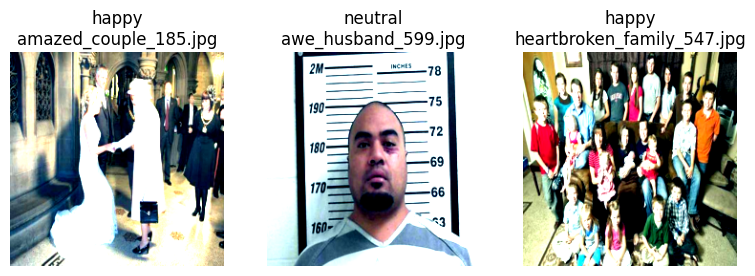

In [6]:
show_batch(expw_train_loader,expw_train_ds.labels,3)

## SFEW Dataset

Creating dataloader objects.

It copies files from a google drive, unzips it and sets that for use

details: da_cv_fer.ds_sfew.DatasetSFEW

In [52]:
# Mounting Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [53]:
sfew = DatasetSFEW()
sfew_train_loader, sfew_val_loader = sfew.get_dataloader()
print(f' length of SFEW dataset : {len(sfew_train_loader.dataset)}')

self.BASE_PATH -dataset,
 self.EXTRACT_DIR-dataset/sfew,
 self.ZIP_FILE_PATH - dataset/SFEW_2.zip 
Directory dataset/sfew created successfully.
No files (including zip file) found in dataset/sfew.Copying file
Starting File copying from /content/gdrive/MyDrive/CV_FER/dataset/SFEW_2.zip to dataset/sfew
File copied successfully from /content/gdrive/MyDrive/CV_FER/dataset/SFEW_2.zip to dataset/sfew
Initiating extraction of dataset/sfew/SFEW_2.zip to dataset/sfew
...completed for dataset/sfew/SFEW_2.zip
dataset/sfew/Train Neutral.zip Neutral
...completed for dataset/sfew/Train/Neutral.zip
dataset/sfew/Train Sad.zip Sad
...completed for dataset/sfew/Train/Sad.zip
dataset/sfew/Train Happy.zip Happy
...completed for dataset/sfew/Train/Happy.zip
dataset/sfew/Train Angry.zip Angry
...completed for dataset/sfew/Train/Angry.zip
dataset/sfew/Train Disgust.zip Disgust
...completed for dataset/sfew/Train/Disgust.zip
dataset/sfew/Train Fear.zip Fear
...completed for dataset/sfew/Train/Fear.zip
dataset

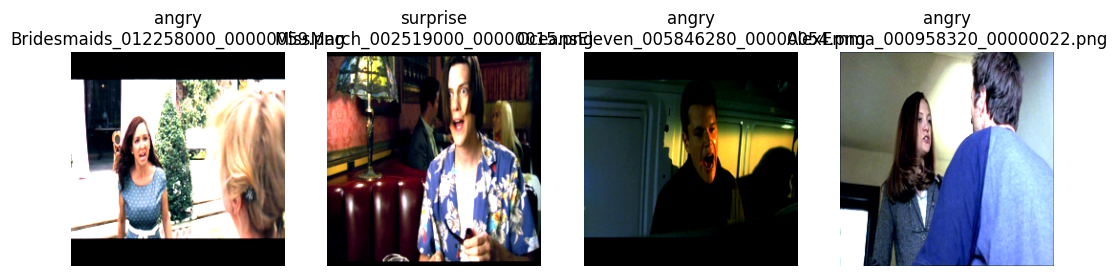

In [54]:
show_batch(sfew_train_loader,sfew.labels,4)

## Initializing Model

In [10]:
model = DANN(num_classes=7, dropout=0.1)
model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s]


DANN(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

### Checking Training - one forward pass
Useful to understand input and output. Specially, sizes of input and output (including batch sizes)

In [11]:
sfew_loader = {'name': 'sfew',
               'train':sfew_train_loader,
               'val':sfew_val_loader
               }

expw_loader = {'name': 'expw',
               'train':expw_train_loader,
               'val':expw_val_loader
               }

data_loader = {'source' : sfew_loader,
               'target' : expw_loader}

# data_loader = {'source_train_loader':sfew_train_loader,
#                'source_val_loader':sfew_val_loader,
#                'target_train_loader':expw_train_loader,
#                'target_val_loader':expw_val_loader}

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = model.to(device)

cuda


In [13]:
for usage, dict_data_loader in data_loader.items(): #[sfew_train_loader,sfew_val_loader,expw_train_loader,expw_val_loader]:
    print('-'*80)
    print(usage)
    # for name, train_loader, val_loader in data_loader.items()
    for k, v in dict_data_loader.items():
      if k == 'name':
        print (f'--------{k} of dataset : {v}--------')
      else:
        print (f'   --------type : {k}--------')
        batch = next(iter(v)) # it may be possible that some datasets have more than 2 outputs, so this strategy is safe
        images, labels = batch[0].to(device), batch[1].to(device)
        print( "Input:\n","Input Image: ",images.shape, ",labels: ",labels.shape)

        x_labels, x_domains, x_features = model(images) # forward pass
        print("Output:\n", "labels: ", x_labels.shape, ",domains: ",x_domains.shape, ",features: ", x_features.shape)




--------------------------------------------------------------------------------
source
--------name of dataset : sfew--------
   --------type : train--------
Input:
 Input Image:  torch.Size([32, 3, 224, 224]) ,labels:  torch.Size([32, 7])
Output:
 labels:  torch.Size([32, 7]) ,domains:  torch.Size([32, 2]) ,features:  torch.Size([32, 1000])
   --------type : val--------
Input:
 Input Image:  torch.Size([32, 3, 224, 224]) ,labels:  torch.Size([32, 7])
Output:
 labels:  torch.Size([32, 7]) ,domains:  torch.Size([32, 2]) ,features:  torch.Size([32, 1000])
--------------------------------------------------------------------------------
target
--------name of dataset : expw--------
   --------type : train--------
Input:
 Input Image:  torch.Size([32, 3, 224, 224]) ,labels:  torch.Size([32, 7])
Output:
 labels:  torch.Size([32, 7]) ,domains:  torch.Size([32, 2]) ,features:  torch.Size([32, 1000])
   --------type : val--------
Input:
 Input Image:  torch.Size([32, 3, 224, 224]) ,labels:  to

In [14]:
# #@title Weight Initialization

# # initializating weights using xavier normal
# def weights_init(m):
#     if isinstance(m, nn.Conv2d):
#       nn.init.xavier_normal_(m.weight)
#     elif isinstance(m, nn.Linear):
#       nn.init.xavier_normal_(m.weight)
#       nn.init.zeros_(m.bias)

# # initializating weights using xavier normal
# def weights_init(m):
#     if isinstance(m, nn.Conv2d):
#       # nn.init.xavier_normal_(m.weight)
#       pass # not initialising Conv layers as they are pretrained
#     elif isinstance(m, nn.Linear):
#       nn.init.xavier_normal_(m.weight) # Linear layers are added on
#       nn.init.zeros_(m.bias)

In [15]:
# #@title Typical Training Function with Learning rate

# def train_model(model,device, data_loader, optimizer, epoch,
#                 class_loss_function = nn.CrossEntropyLoss() ):
#     print(f'epoch = {epoch+1}...in training function')

#     model.train() # setting model to training
#     model.to(device)

#     pbar = tqdm(data_loader) # putting the dataloader in progress bar

#     processed = 0 # to understand accuracy, used in denominator
#     epoch_loss = 0.0

#     for batch_idx, batch in enumerate(pbar):
#         images, labels = batch[0].to(device), batch[1].to(device) # batch of images and labels

#         optimizer.zero_grad() # setting gradients to zero to avoid accumulation

#         class_output, _ , _ = model(images) # forward pass, output = {class, domain, feature}

#         class_loss = class_loss_function(class_output,labels) # Calculate Loss
#         epoch_loss += class_loss.item()

#         class_loss.backward() #backpropogation, creating gradients

#         optimizer.step() # updating the params

#         processed += len(images)
#         curr_lr = optimizer.param_groups[0]['lr']

#         pbar.set_description(desc= f'Loss={class_loss.item()} Batch_id={batch_idx+1} Epoch Average loss={epoch_loss/processed:0.8f} LR={curr_lr:0.6f}')

#     return float("{:.8f}".format(epoch_loss/processed)),  curr_lr

In [16]:
# def get_correct_predictions(prediction, labels):
#     """
#     Function to return total number of correct predictions
#     :param prediction: Model predictions on a given sample of data
#     :param labels: Correct labels of a given sample of data
#     :return: Number of correct predictions
#     """
#     # print(prediction)
#     # print(prediction.argmax(dim=1))
#     # print(f'labels = {labels}, labels.argmax ={labels.argmax(dim=1)}')
#     # # print(prediction.argmax(dim=1).eq(labels))
#     # # print(prediction.argmax(dim=1).eq(labels).sum())
#     # # print(prediction.argmax(dim=1).eq(labels).sum().item())
#     # # return prediction.argmax(dim=1).eq(labels).sum().item()
#     # print(prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum())
#     # print(prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item())
#     return prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item()

In [17]:


# #@title Typical Test Function
# def test_model(model, device, data_loader, mode= 'test',
#                class_loss_function = nn.CrossEntropyLoss() ):
#     model.eval() # evaluation mode

#     # variables to track loss and accuracy
#     test_loss = 0.0
#     correct = 0

#     # Disable gradient updation
#     with torch.no_grad():
#         # Iterate over each batch and fetch images and labels from the batch
#         for batch_idx, batch in enumerate(data_loader):
#             images, labels = batch[0].to(device), batch[1].to(device)

#             class_output, _ , _ = model(images) # forward pass, output = {class, domain, feature}
#             class_loss = class_loss_function(class_output,labels) # Calculate Loss

#             test_loss += class_loss.item() # sum up batch loss

#             # Sum up batch correct predictions
#             correct += get_correct_predictions(class_output, labels)

#     # Calculate test loss for a epoch
#     test_loss /= len(data_loader.dataset)

#     print('Test / Val: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(data_loader.dataset),
#         100. * correct / len(data_loader.dataset)))


#     return correct, test_loss



## Non DANN: Training, Validating, Saving

In [18]:
runconfig = RunConfig()
device = runconfig.device

non_dann_model = DANN(num_classes=7)
non_dann_model = non_dann_model.to(device)
# non_dann_model.apply(weights_init) # initializing model, only linear layers

#learning rate
lr = float(runconfig.inital_lr)

# optimizer
optimizer = optim.SGD(non_dann_model.parameters(), lr = lr, momentum = 0.9)

# loss functions
criterion_class = (runconfig.criterion_class).to(device=device)
criterion_domain = (runconfig.criterion_domain).to(device=device)

# loss accumulation
train_losses = [] # to capture train losses over training epochs
val_losses = [] # to capture validation loss over epochs

# Epochs
EPOCHS = runconfig.NUM_EPOCHS
print("EPOCHS", EPOCHS)
# EPOCHS =2 # overriding

print('------ Training started for Non DANN Model ---- ')
print(f'starting LR : {lr}')
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1, " of ", EPOCHS)

    #Train Model
    avg_epoch_loss, curr_lr = train_model(model = non_dann_model,
                                          device = device,
                                          data_loader = sfew_train_loader,
                                          optimizer = optimizer,
                                          epoch = epoch,
                                          class_loss_function = criterion_class)
    train_losses.append(avg_epoch_loss)
    #TODO: ADD SCHEDULER

    #Validate Model
    correct, avg_epoch_val_loss = test_model(model= non_dann_model,
                                    device= device,
                                    data_loader = sfew_val_loader,
                                    class_loss_function = criterion_class
                                    )

    val_losses.append(avg_epoch_val_loss)

correct, test_loss_source = test_model(model= non_dann_model,
                                    device= device,
                                    data_loader = sfew_val_loader, # source val loader
                                    class_loss_function = criterion_class)

correct, test_loss_target = test_model(model= non_dann_model,
                                    device= device,
                                    data_loader = expw_val_loader, # target val loader
                                    class_loss_function = criterion_class)

dict_non_dann_losses_list_sfew_expw = {'train_losses' : train_losses,
                                       'val_losses': val_losses,
                                       'test_loss_source' : test_loss_source,
                                       'test_loss_target' : test_loss_target,
                                       'epoch_convergence' : 0  }




EPOCHS 100
------ Training started for Non DANN Model ---- 
starting LR : 0.005
EPOCH: 1  of  100
epoch = 1...in training function


Loss=1.699747920036316 Batch_id=30 Epoch Average loss=0.05928225 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.74it/s]


Test / Val: Average loss: 0.0611, Accuracy: 74/436 (16.97%)

EPOCH: 2  of  100
epoch = 2...in training function


Loss=1.6786996126174927 Batch_id=30 Epoch Average loss=0.05559682 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.60it/s]


Test / Val: Average loss: 0.0607, Accuracy: 98/436 (22.48%)

EPOCH: 3  of  100
epoch = 3...in training function


Loss=1.5784496068954468 Batch_id=30 Epoch Average loss=0.04768372 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.95it/s]


Test / Val: Average loss: 0.0607, Accuracy: 108/436 (24.77%)

EPOCH: 4  of  100
epoch = 4...in training function


Loss=1.1754692792892456 Batch_id=30 Epoch Average loss=0.03484819 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.98it/s]


Test / Val: Average loss: 0.0707, Accuracy: 118/436 (27.06%)

EPOCH: 5  of  100
epoch = 5...in training function


Loss=0.9023299217224121 Batch_id=30 Epoch Average loss=0.02109400 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.89it/s]


Test / Val: Average loss: 0.0825, Accuracy: 85/436 (19.50%)

EPOCH: 6  of  100
epoch = 6...in training function


Loss=0.5617715716362 Batch_id=30 Epoch Average loss=0.01394098 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.85it/s]


Test / Val: Average loss: 0.0862, Accuracy: 98/436 (22.48%)

EPOCH: 7  of  100
epoch = 7...in training function


Loss=0.2783118784427643 Batch_id=30 Epoch Average loss=0.00887423 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.79it/s]


Test / Val: Average loss: 0.0972, Accuracy: 107/436 (24.54%)

EPOCH: 8  of  100
epoch = 8...in training function


Loss=0.4115753769874573 Batch_id=30 Epoch Average loss=0.00626630 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.88it/s]


Test / Val: Average loss: 0.0968, Accuracy: 117/436 (26.83%)

EPOCH: 9  of  100
epoch = 9...in training function


Loss=0.10582321882247925 Batch_id=30 Epoch Average loss=0.00478390 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.76it/s]


Test / Val: Average loss: 0.1048, Accuracy: 103/436 (23.62%)

EPOCH: 10  of  100
epoch = 10...in training function


Loss=0.09254975616931915 Batch_id=30 Epoch Average loss=0.00210446 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.56it/s]


Test / Val: Average loss: 0.1132, Accuracy: 108/436 (24.77%)

EPOCH: 11  of  100
epoch = 11...in training function


Loss=0.1207854151725769 Batch_id=30 Epoch Average loss=0.00172298 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.53it/s]


Test / Val: Average loss: 0.1224, Accuracy: 99/436 (22.71%)

EPOCH: 12  of  100
epoch = 12...in training function


Loss=0.09313417971134186 Batch_id=30 Epoch Average loss=0.00112031 LR=0.005000: 100%|██████████| 30/30 [00:12<00:00,  2.48it/s]


Test / Val: Average loss: 0.1394, Accuracy: 94/436 (21.56%)

EPOCH: 13  of  100
epoch = 13...in training function


Loss=0.010648718103766441 Batch_id=30 Epoch Average loss=0.00101221 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.53it/s]


Test / Val: Average loss: 0.1305, Accuracy: 121/436 (27.75%)

EPOCH: 14  of  100
epoch = 14...in training function


Loss=0.00421836506575346 Batch_id=30 Epoch Average loss=0.00116675 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.53it/s]


Test / Val: Average loss: 0.1281, Accuracy: 101/436 (23.17%)

EPOCH: 15  of  100
epoch = 15...in training function


Loss=0.0034937255550175905 Batch_id=30 Epoch Average loss=0.00072111 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.84it/s]


Test / Val: Average loss: 0.1343, Accuracy: 91/436 (20.87%)

EPOCH: 16  of  100
epoch = 16...in training function


Loss=0.05107605829834938 Batch_id=30 Epoch Average loss=0.00054414 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.92it/s]


Test / Val: Average loss: 0.1324, Accuracy: 100/436 (22.94%)

EPOCH: 17  of  100
epoch = 17...in training function


Loss=0.0023353949654847383 Batch_id=30 Epoch Average loss=0.00047295 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.88it/s]


Test / Val: Average loss: 0.1392, Accuracy: 98/436 (22.48%)

EPOCH: 18  of  100
epoch = 18...in training function


Loss=0.03629143908619881 Batch_id=30 Epoch Average loss=0.00041370 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.65it/s]


Test / Val: Average loss: 0.1412, Accuracy: 101/436 (23.17%)

EPOCH: 19  of  100
epoch = 19...in training function


Loss=0.0015884347958490252 Batch_id=30 Epoch Average loss=0.00032536 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Test / Val: Average loss: 0.1410, Accuracy: 105/436 (24.08%)

EPOCH: 20  of  100
epoch = 20...in training function


Loss=0.001880853669717908 Batch_id=30 Epoch Average loss=0.00019748 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.92it/s]


Test / Val: Average loss: 0.1488, Accuracy: 87/436 (19.95%)

EPOCH: 21  of  100
epoch = 21...in training function


Loss=0.0005042937700636685 Batch_id=30 Epoch Average loss=0.00016362 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Test / Val: Average loss: 0.1477, Accuracy: 90/436 (20.64%)

EPOCH: 22  of  100
epoch = 22...in training function


Loss=0.002279625041410327 Batch_id=30 Epoch Average loss=0.00017451 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.81it/s]


Test / Val: Average loss: 0.1496, Accuracy: 90/436 (20.64%)

EPOCH: 23  of  100
epoch = 23...in training function


Loss=0.005239523947238922 Batch_id=30 Epoch Average loss=0.00015139 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Test / Val: Average loss: 0.1512, Accuracy: 97/436 (22.25%)

EPOCH: 24  of  100
epoch = 24...in training function


Loss=0.0018608453683555126 Batch_id=30 Epoch Average loss=0.00022313 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.85it/s]


Test / Val: Average loss: 0.1501, Accuracy: 92/436 (21.10%)

EPOCH: 25  of  100
epoch = 25...in training function


Loss=0.0006618279148824513 Batch_id=30 Epoch Average loss=0.00017591 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.91it/s]


Test / Val: Average loss: 0.1495, Accuracy: 94/436 (21.56%)

EPOCH: 26  of  100
epoch = 26...in training function


Loss=0.003835325362160802 Batch_id=30 Epoch Average loss=0.00014624 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.64it/s]


Test / Val: Average loss: 0.1501, Accuracy: 93/436 (21.33%)

EPOCH: 27  of  100
epoch = 27...in training function


Loss=0.0002579236461315304 Batch_id=30 Epoch Average loss=0.00015428 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.62it/s]


Test / Val: Average loss: 0.1521, Accuracy: 89/436 (20.41%)

EPOCH: 28  of  100
epoch = 28...in training function


Loss=0.0003612360160332173 Batch_id=30 Epoch Average loss=0.00013436 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.59it/s]


Test / Val: Average loss: 0.1503, Accuracy: 95/436 (21.79%)

EPOCH: 29  of  100
epoch = 29...in training function


Loss=0.045705899596214294 Batch_id=30 Epoch Average loss=0.00016017 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.55it/s]


Test / Val: Average loss: 0.1523, Accuracy: 94/436 (21.56%)

EPOCH: 30  of  100
epoch = 30...in training function


Loss=0.0001722022716421634 Batch_id=30 Epoch Average loss=0.00011881 LR=0.005000: 100%|██████████| 30/30 [00:12<00:00,  2.49it/s]


Test / Val: Average loss: 0.1516, Accuracy: 96/436 (22.02%)

EPOCH: 31  of  100
epoch = 31...in training function


Loss=0.0014091238845139742 Batch_id=30 Epoch Average loss=0.00017006 LR=0.005000: 100%|██████████| 30/30 [00:12<00:00,  2.49it/s]


Test / Val: Average loss: 0.1532, Accuracy: 98/436 (22.48%)

EPOCH: 32  of  100
epoch = 32...in training function


Loss=0.0006080543389543891 Batch_id=30 Epoch Average loss=0.00012849 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.61it/s]


Test / Val: Average loss: 0.1552, Accuracy: 94/436 (21.56%)

EPOCH: 33  of  100
epoch = 33...in training function


Loss=0.0009633004665374756 Batch_id=30 Epoch Average loss=0.00013834 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.83it/s]


Test / Val: Average loss: 0.1545, Accuracy: 98/436 (22.48%)

EPOCH: 34  of  100
epoch = 34...in training function


Loss=0.002070456277579069 Batch_id=30 Epoch Average loss=0.00010719 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.63it/s]


Test / Val: Average loss: 0.1568, Accuracy: 98/436 (22.48%)

EPOCH: 35  of  100
epoch = 35...in training function


Loss=0.00016824770136736333 Batch_id=30 Epoch Average loss=0.00012016 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Test / Val: Average loss: 0.1583, Accuracy: 98/436 (22.48%)

EPOCH: 36  of  100
epoch = 36...in training function


Loss=0.00037829120992682874 Batch_id=30 Epoch Average loss=0.00012201 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.89it/s]


Test / Val: Average loss: 0.1602, Accuracy: 98/436 (22.48%)

EPOCH: 37  of  100
epoch = 37...in training function


Loss=0.0004964412073604763 Batch_id=30 Epoch Average loss=0.00010433 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Test / Val: Average loss: 0.1579, Accuracy: 100/436 (22.94%)

EPOCH: 38  of  100
epoch = 38...in training function


Loss=0.0007261164719238877 Batch_id=30 Epoch Average loss=0.00011754 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Test / Val: Average loss: 0.1593, Accuracy: 100/436 (22.94%)

EPOCH: 39  of  100
epoch = 39...in training function


Loss=0.0003577360766939819 Batch_id=30 Epoch Average loss=0.00014003 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.91it/s]


Test / Val: Average loss: 0.1620, Accuracy: 102/436 (23.39%)

EPOCH: 40  of  100
epoch = 40...in training function


Loss=0.0015253263991326094 Batch_id=30 Epoch Average loss=0.00017857 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.90it/s]


Test / Val: Average loss: 0.1583, Accuracy: 97/436 (22.25%)

EPOCH: 41  of  100
epoch = 41...in training function


Loss=8.396350312978029e-05 Batch_id=30 Epoch Average loss=0.00010626 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.91it/s]


Test / Val: Average loss: 0.1631, Accuracy: 99/436 (22.71%)

EPOCH: 42  of  100
epoch = 42...in training function


Loss=0.001368876313790679 Batch_id=30 Epoch Average loss=0.00010367 LR=0.005000: 100%|██████████| 30/30 [00:12<00:00,  2.48it/s]


Test / Val: Average loss: 0.1610, Accuracy: 98/436 (22.48%)

EPOCH: 43  of  100
epoch = 43...in training function


Loss=0.0003188425616826862 Batch_id=30 Epoch Average loss=0.00012526 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s]


Test / Val: Average loss: 0.1609, Accuracy: 97/436 (22.25%)

EPOCH: 44  of  100
epoch = 44...in training function


Loss=0.0003004892496392131 Batch_id=30 Epoch Average loss=0.00012551 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.65it/s]


Test / Val: Average loss: 0.1618, Accuracy: 97/436 (22.25%)

EPOCH: 45  of  100
epoch = 45...in training function


Loss=0.00020629218488465995 Batch_id=30 Epoch Average loss=0.00011946 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.58it/s]


Test / Val: Average loss: 0.1613, Accuracy: 99/436 (22.71%)

EPOCH: 46  of  100
epoch = 46...in training function


Loss=0.004544432274997234 Batch_id=30 Epoch Average loss=0.00007128 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.55it/s]


Test / Val: Average loss: 0.1611, Accuracy: 100/436 (22.94%)

EPOCH: 47  of  100
epoch = 47...in training function


Loss=0.0001112819736590609 Batch_id=30 Epoch Average loss=0.00013054 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.54it/s]


Test / Val: Average loss: 0.1637, Accuracy: 101/436 (23.17%)

EPOCH: 48  of  100
epoch = 48...in training function


Loss=0.0003487155190669 Batch_id=30 Epoch Average loss=0.00014321 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.51it/s]


Test / Val: Average loss: 0.1649, Accuracy: 96/436 (22.02%)

EPOCH: 49  of  100
epoch = 49...in training function


Loss=0.00031541712814942 Batch_id=30 Epoch Average loss=0.00030425 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.61it/s]


Test / Val: Average loss: 0.1641, Accuracy: 92/436 (21.10%)

EPOCH: 50  of  100
epoch = 50...in training function


Loss=0.042208679020404816 Batch_id=30 Epoch Average loss=0.00015493 LR=0.005000: 100%|██████████| 30/30 [00:12<00:00,  2.45it/s]


Test / Val: Average loss: 0.1599, Accuracy: 99/436 (22.71%)

EPOCH: 51  of  100
epoch = 51...in training function


Loss=0.0004384359926916659 Batch_id=30 Epoch Average loss=0.00011343 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.72it/s]


Test / Val: Average loss: 0.1606, Accuracy: 99/436 (22.71%)

EPOCH: 52  of  100
epoch = 52...in training function


Loss=0.00035159921390004456 Batch_id=30 Epoch Average loss=0.00014338 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.80it/s]


Test / Val: Average loss: 0.1590, Accuracy: 99/436 (22.71%)

EPOCH: 53  of  100
epoch = 53...in training function


Loss=0.0004922767402604222 Batch_id=30 Epoch Average loss=0.00015078 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.88it/s]


Test / Val: Average loss: 0.1582, Accuracy: 101/436 (23.17%)

EPOCH: 54  of  100
epoch = 54...in training function


Loss=0.0001491458824602887 Batch_id=30 Epoch Average loss=0.00008260 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.89it/s]


Test / Val: Average loss: 0.1574, Accuracy: 99/436 (22.71%)

EPOCH: 55  of  100
epoch = 55...in training function


Loss=0.00019608932780101895 Batch_id=30 Epoch Average loss=0.00012088 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.88it/s]


Test / Val: Average loss: 0.1613, Accuracy: 93/436 (21.33%)

EPOCH: 56  of  100
epoch = 56...in training function


Loss=0.00035382877103984356 Batch_id=30 Epoch Average loss=0.00007990 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.93it/s]


Test / Val: Average loss: 0.1621, Accuracy: 97/436 (22.25%)

EPOCH: 57  of  100
epoch = 57...in training function


Loss=0.0018594461726024747 Batch_id=30 Epoch Average loss=0.00015471 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.86it/s]


Test / Val: Average loss: 0.1612, Accuracy: 100/436 (22.94%)

EPOCH: 58  of  100
epoch = 58...in training function


Loss=0.012292138300836086 Batch_id=30 Epoch Average loss=0.00015000 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.50it/s]


Test / Val: Average loss: 0.1620, Accuracy: 93/436 (21.33%)

EPOCH: 59  of  100
epoch = 59...in training function


Loss=0.00036265025846660137 Batch_id=30 Epoch Average loss=0.00010373 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.74it/s]


Test / Val: Average loss: 0.1592, Accuracy: 100/436 (22.94%)

EPOCH: 60  of  100
epoch = 60...in training function


Loss=0.00017120360280387104 Batch_id=30 Epoch Average loss=0.00007282 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.72it/s]


Test / Val: Average loss: 0.1568, Accuracy: 109/436 (25.00%)

EPOCH: 61  of  100
epoch = 61...in training function


Loss=0.0012730320449918509 Batch_id=30 Epoch Average loss=0.00010137 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.67it/s]


Test / Val: Average loss: 0.1621, Accuracy: 105/436 (24.08%)

EPOCH: 62  of  100
epoch = 62...in training function


Loss=0.00018831732450053096 Batch_id=30 Epoch Average loss=0.00006431 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.59it/s]


Test / Val: Average loss: 0.1590, Accuracy: 107/436 (24.54%)

EPOCH: 63  of  100
epoch = 63...in training function


Loss=0.0004079752543475479 Batch_id=30 Epoch Average loss=0.00005674 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.58it/s]


Test / Val: Average loss: 0.1599, Accuracy: 106/436 (24.31%)

EPOCH: 64  of  100
epoch = 64...in training function


Loss=0.022962363436818123 Batch_id=30 Epoch Average loss=0.00009252 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.57it/s]


Test / Val: Average loss: 0.1610, Accuracy: 105/436 (24.08%)

EPOCH: 65  of  100
epoch = 65...in training function


Loss=0.000133465466205962 Batch_id=30 Epoch Average loss=0.00010024 LR=0.005000: 100%|██████████| 30/30 [00:12<00:00,  2.48it/s]


Test / Val: Average loss: 0.1593, Accuracy: 108/436 (24.77%)

EPOCH: 66  of  100
epoch = 66...in training function


Loss=0.019437292590737343 Batch_id=30 Epoch Average loss=0.00006569 LR=0.005000: 100%|██████████| 30/30 [00:12<00:00,  2.43it/s]


Test / Val: Average loss: 0.1636, Accuracy: 100/436 (22.94%)

EPOCH: 67  of  100
epoch = 67...in training function


Loss=0.00011179716238984838 Batch_id=30 Epoch Average loss=0.00027255 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.58it/s]


Test / Val: Average loss: 0.1602, Accuracy: 97/436 (22.25%)

EPOCH: 68  of  100
epoch = 68...in training function


Loss=0.0017979873809963465 Batch_id=30 Epoch Average loss=0.00014933 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.81it/s]


Test / Val: Average loss: 0.1637, Accuracy: 103/436 (23.62%)

EPOCH: 69  of  100
epoch = 69...in training function


Loss=0.038944728672504425 Batch_id=30 Epoch Average loss=0.00009561 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.88it/s]


Test / Val: Average loss: 0.1638, Accuracy: 98/436 (22.48%)

EPOCH: 70  of  100
epoch = 70...in training function


Loss=0.01513830479234457 Batch_id=30 Epoch Average loss=0.00006801 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.90it/s]


Test / Val: Average loss: 0.1652, Accuracy: 101/436 (23.17%)

EPOCH: 71  of  100
epoch = 71...in training function


Loss=0.012828015722334385 Batch_id=30 Epoch Average loss=0.00008689 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.91it/s]


Test / Val: Average loss: 0.1611, Accuracy: 104/436 (23.85%)

EPOCH: 72  of  100
epoch = 72...in training function


Loss=0.00030019873520359397 Batch_id=30 Epoch Average loss=0.00015819 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Test / Val: Average loss: 0.1643, Accuracy: 103/436 (23.62%)

EPOCH: 73  of  100
epoch = 73...in training function


Loss=0.00022808206267654896 Batch_id=30 Epoch Average loss=0.00006596 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Test / Val: Average loss: 0.1635, Accuracy: 102/436 (23.39%)

EPOCH: 74  of  100
epoch = 74...in training function


Loss=8.344316302100196e-05 Batch_id=30 Epoch Average loss=0.00010373 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.56it/s]


Test / Val: Average loss: 0.1648, Accuracy: 100/436 (22.94%)

EPOCH: 75  of  100
epoch = 75...in training function


Loss=0.06292148679494858 Batch_id=30 Epoch Average loss=0.00012018 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.90it/s]


Test / Val: Average loss: 0.1632, Accuracy: 103/436 (23.62%)

EPOCH: 76  of  100
epoch = 76...in training function


Loss=0.0008692917181178927 Batch_id=30 Epoch Average loss=0.00007568 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.86it/s]


Test / Val: Average loss: 0.1609, Accuracy: 108/436 (24.77%)

EPOCH: 77  of  100
epoch = 77...in training function


Loss=0.0001597728842170909 Batch_id=30 Epoch Average loss=0.00007260 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.93it/s]


Test / Val: Average loss: 0.1658, Accuracy: 103/436 (23.62%)

EPOCH: 78  of  100
epoch = 78...in training function


Loss=0.00021205804659985006 Batch_id=30 Epoch Average loss=0.00013017 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.88it/s]


Test / Val: Average loss: 0.1665, Accuracy: 100/436 (22.94%)

EPOCH: 79  of  100
epoch = 79...in training function


Loss=0.00010934926103800535 Batch_id=30 Epoch Average loss=0.00016733 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.90it/s]


Test / Val: Average loss: 0.1635, Accuracy: 102/436 (23.39%)

EPOCH: 80  of  100
epoch = 80...in training function


Loss=0.00011834428005386144 Batch_id=30 Epoch Average loss=0.00010591 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.85it/s]


Test / Val: Average loss: 0.1634, Accuracy: 106/436 (24.31%)

EPOCH: 81  of  100
epoch = 81...in training function


Loss=0.01838506944477558 Batch_id=30 Epoch Average loss=0.00008899 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.80it/s]


Test / Val: Average loss: 0.1640, Accuracy: 104/436 (23.85%)

EPOCH: 82  of  100
epoch = 82...in training function


Loss=8.807607082417235e-05 Batch_id=30 Epoch Average loss=0.00007474 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.61it/s]


Test / Val: Average loss: 0.1655, Accuracy: 104/436 (23.85%)

EPOCH: 83  of  100
epoch = 83...in training function


Loss=0.0005083609721623361 Batch_id=30 Epoch Average loss=0.00006324 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.64it/s]


Test / Val: Average loss: 0.1638, Accuracy: 102/436 (23.39%)

EPOCH: 84  of  100
epoch = 84...in training function


Loss=0.00010635215585352853 Batch_id=30 Epoch Average loss=0.00008945 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.56it/s]


Test / Val: Average loss: 0.1647, Accuracy: 108/436 (24.77%)

EPOCH: 85  of  100
epoch = 85...in training function


Loss=6.706546992063522e-05 Batch_id=30 Epoch Average loss=0.00009003 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.52it/s]


Test / Val: Average loss: 0.1648, Accuracy: 104/436 (23.85%)

EPOCH: 86  of  100
epoch = 86...in training function


Loss=0.00013624015264213085 Batch_id=30 Epoch Average loss=0.00005543 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.69it/s]


Test / Val: Average loss: 0.1652, Accuracy: 108/436 (24.77%)

EPOCH: 87  of  100
epoch = 87...in training function


Loss=0.0005937012610957026 Batch_id=30 Epoch Average loss=0.00009752 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.84it/s]


Test / Val: Average loss: 0.1640, Accuracy: 106/436 (24.31%)

EPOCH: 88  of  100
epoch = 88...in training function


Loss=0.00014191490481607616 Batch_id=30 Epoch Average loss=0.00005899 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.91it/s]


Test / Val: Average loss: 0.1654, Accuracy: 111/436 (25.46%)

EPOCH: 89  of  100
epoch = 89...in training function


Loss=0.0002900300023611635 Batch_id=30 Epoch Average loss=0.00006426 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.88it/s]


Test / Val: Average loss: 0.1661, Accuracy: 104/436 (23.85%)

EPOCH: 90  of  100
epoch = 90...in training function


Loss=0.00023668537323828787 Batch_id=30 Epoch Average loss=0.00005186 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.60it/s]


Test / Val: Average loss: 0.1710, Accuracy: 107/436 (24.54%)

EPOCH: 91  of  100
epoch = 91...in training function


Loss=0.00028147592092864215 Batch_id=30 Epoch Average loss=0.00006643 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Test / Val: Average loss: 0.1697, Accuracy: 102/436 (23.39%)

EPOCH: 92  of  100
epoch = 92...in training function


Loss=6.895353726577014e-05 Batch_id=30 Epoch Average loss=0.00005538 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.88it/s]


Test / Val: Average loss: 0.1682, Accuracy: 100/436 (22.94%)

EPOCH: 93  of  100
epoch = 93...in training function


Loss=5.1057777454843745e-05 Batch_id=30 Epoch Average loss=0.00005293 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.92it/s]


Test / Val: Average loss: 0.1676, Accuracy: 101/436 (23.17%)

EPOCH: 94  of  100
epoch = 94...in training function


Loss=0.00047557224752381444 Batch_id=30 Epoch Average loss=0.00006892 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.88it/s]


Test / Val: Average loss: 0.1673, Accuracy: 104/436 (23.85%)

EPOCH: 95  of  100
epoch = 95...in training function


Loss=7.242194260470569e-05 Batch_id=30 Epoch Average loss=0.00008371 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.91it/s]


Test / Val: Average loss: 0.1707, Accuracy: 103/436 (23.62%)

EPOCH: 96  of  100
epoch = 96...in training function


Loss=0.0005522207356989384 Batch_id=30 Epoch Average loss=0.00006264 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.85it/s]


Test / Val: Average loss: 0.1681, Accuracy: 99/436 (22.71%)

EPOCH: 97  of  100
epoch = 97...in training function


Loss=0.000305247085634619 Batch_id=30 Epoch Average loss=0.00004934 LR=0.005000: 100%|██████████| 30/30 [00:10<00:00,  2.84it/s]


Test / Val: Average loss: 0.1713, Accuracy: 102/436 (23.39%)

EPOCH: 98  of  100
epoch = 98...in training function


Loss=6.288020813371986e-05 Batch_id=30 Epoch Average loss=0.00007507 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.54it/s]


Test / Val: Average loss: 0.1688, Accuracy: 104/436 (23.85%)

EPOCH: 99  of  100
epoch = 99...in training function


Loss=0.00019953912124037743 Batch_id=30 Epoch Average loss=0.00005763 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.71it/s]


Test / Val: Average loss: 0.1691, Accuracy: 106/436 (24.31%)

EPOCH: 100  of  100
epoch = 100...in training function


Loss=8.028656884562224e-05 Batch_id=30 Epoch Average loss=0.00005033 LR=0.005000: 100%|██████████| 30/30 [00:11<00:00,  2.71it/s]


Test / Val: Average loss: 0.1694, Accuracy: 101/436 (23.17%)

Test / Val: Average loss: 0.1695, Accuracy: 101/436 (23.17%)

Test / Val: Average loss: 0.1707, Accuracy: 2507/13620 (18.41%)



In [19]:
print(dict_non_dann_losses_list_sfew_expw)

{'train_losses': [0.05928225, 0.05559682, 0.04768372, 0.03484819, 0.021094, 0.01394098, 0.00887423, 0.0062663, 0.0047839, 0.00210446, 0.00172298, 0.00112031, 0.00101221, 0.00116675, 0.00072111, 0.00054414, 0.00047295, 0.0004137, 0.00032536, 0.00019748, 0.00016362, 0.00017451, 0.00015139, 0.00022313, 0.00017591, 0.00014624, 0.00015428, 0.00013436, 0.00016017, 0.00011881, 0.00017006, 0.00012849, 0.00013834, 0.00010719, 0.00012016, 0.00012201, 0.00010433, 0.00011754, 0.00014003, 0.00017857, 0.00010626, 0.00010367, 0.00012526, 0.00012551, 0.00011946, 7.128e-05, 0.00013054, 0.00014321, 0.00030425, 0.00015493, 0.00011343, 0.00014338, 0.00015078, 8.26e-05, 0.00012088, 7.99e-05, 0.00015471, 0.00015, 0.00010373, 7.282e-05, 0.00010137, 6.431e-05, 5.674e-05, 9.252e-05, 0.00010024, 6.569e-05, 0.00027255, 0.00014933, 9.561e-05, 6.801e-05, 8.689e-05, 0.00015819, 6.596e-05, 0.00010373, 0.00012018, 7.568e-05, 7.26e-05, 0.00013017, 0.00016733, 0.00010591, 8.899e-05, 7.474e-05, 6.324e-05, 8.945e-05, 9.0

### Saving NON DANN Model

In [20]:
# # TODO: get this information from config
# MODEL_DIR = "models"
# NON_DANN_SFEW_DIR = Path(MODEL_DIR,"non_dann_sfew")
# NON_DANN_SFEW_DIR

# print(MODEL_DIR, NON_DANN_SFEW_DIR)

In [21]:
MODEL_DIR = dataconfig.MODEL_DIR
NON_DANN_SFEW_DIR = dataconfig.NON_DANN_SFEW_DIR
print(MODEL_DIR, NON_DANN_SFEW_DIR)

/content/gdrive/MyDrive/CV_FER/models /content/gdrive/MyDrive/CV_FER/models/non_dann_sfew


In [22]:
model_name = "non_dann_sfew_" +str(time.strftime("%d_%m"))+ ".pt"
# dataconfig = DataConfig()
# NON_DANN_SFEW_DIR = dataconfig.NON_DANN_SFEW_DIR
if not NON_DANN_SFEW_DIR.exists():
    # Create the directory
    NON_DANN_SFEW_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {NON_DANN_SFEW_DIR} created successfully.')
else:
    print(f'Directory {NON_DANN_SFEW_DIR} already exists.')

torch.save(non_dann_model.state_dict(), Path(NON_DANN_SFEW_DIR,model_name))

Directory /content/gdrive/MyDrive/CV_FER/models/non_dann_sfew already exists.


In [23]:
#@title Plotting Training and Validation Loss Function
def plot_loss_curves(dict_non_dann_losses_list_sfew, mode = "train_losses"):
    fig=plt.figure(figsize=(10,20))
    fig.add_subplot(5, 1, 2)
    # for embedding in dict_emb_file.keys():
    list1_to_plot= dict_non_dann_losses_list_sfew[mode]
    plt.plot(range(1,len(list1_to_plot)+1),list1_to_plot, label = 'Non DANN ' + 'SFEW')
    plt.xlabel('number of epochs', fontsize=10)
    plt.ylabel(str(mode), fontsize=10)
    plt.legend(loc = 'upper right')
    plt.title(" "+mode)
    plt.show()

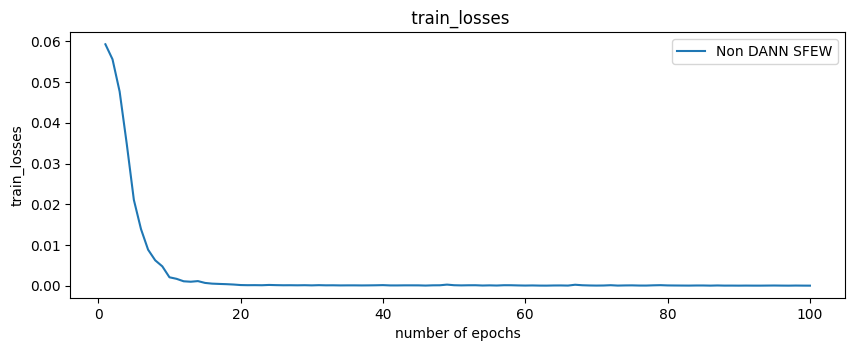

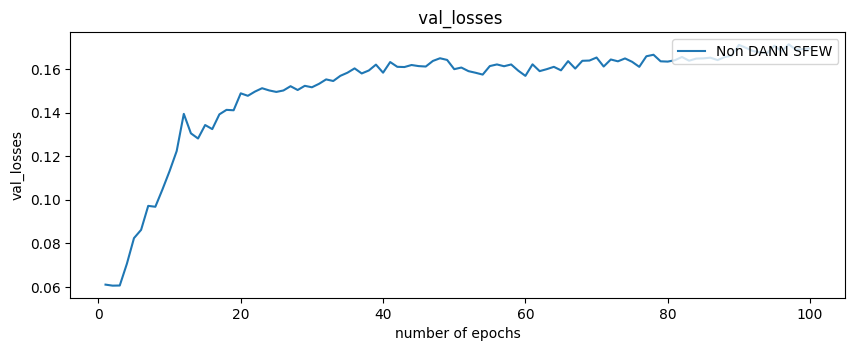

In [24]:
plot_loss_curves(dict_non_dann_losses_list_sfew_expw,mode='train_losses')
plot_loss_curves(dict_non_dann_losses_list_sfew_expw,mode='val_losses')

In [25]:
model_name = model_name #"non_dann_sfew_19_12.pt"

## Loading NON DANN Model for DANN and DANN EWC


In [26]:

loaded_model_non_dann = DANN(num_classes=7) # skeleton copy
loaded_model_non_dann.load_state_dict(torch.load(Path(NON_DANN_SFEW_DIR, model_name),map_location=torch.device(device)))
model_dann = loaded_model_non_dann # saves training time - check with all
model_dann_ewc = loaded_model_non_dann # saves training time - check with all

# print(model_dann)

In [27]:
# #checking if the models are same weights, i.e. copy has worked fine
# for p1, p2 in zip(non_dann_model.parameters(), model_dann.parameters()):
#     if p1.data.ne(p2.data).sum() > 0:
#         print ('False')
# print ('True')

## DANN Execution :  Training, Validating, Saving


In [28]:

def execute_dann(model,device,
                     source_train_loader, source_val_loader,
                     target_train_loader, target_val_loader,
                     optimizer,
                     n_epochs, # total number of epochs (different from individual epoch)
                     class_loss_function = nn.CrossEntropyLoss(),
                     domain_loss_function = nn.BCEWithLogitsLoss() ):

    train_losses = [] # to capture train losses over training epochs
    val_losses = [] # to capture validation loss over epochs
    epoch_converge = epoch
    max_batches = min(len(source_train_loader), len(target_train_loader)) # Trying to check which is having less batches.
    model = model.to(device)
    # model.apply(weights_init) # TODO: skipping weights update - we can experimentation later on, and see if this helps
    list_alpha =[]


    for epoch_idx in range(n_epochs):
        print(f'epoch = {epoch_idx+1}...in DANN execution function')
        source_iterator = iter(source_train_loader)
        target_iterator = iter (target_train_loader)
        epoch_task_loss = 0
        epoch_domain_loss =  0
        epoch_total_loss = 0
        processed = 0

        for batch_idx in range(max_batches-1):
            p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
            alpha = 2. / (1. + np.exp(-10 * p)) - 1
            list_alpha.append(alpha)
            alpha = torch.tensor(alpha)

            model.train() # everytime ?
            optimizer.zero_grad() # flushing out the accumulated gradients

            #---------------------Source Dataset Training ------------------------#
            source_batch = next(source_iterator)
            source_images, source_labels = source_batch[0].to(device), source_batch[1].to(device) # getting images and labels, on device
            source_class_outputs, source_domain_outputs, _ = model(source_images, alpha=alpha) # forward pass, output = {class, domain, feature}


            loss_source_class = class_loss_function(source_class_outputs, source_labels) # calculating class loss

            source_domain_inputs = torch.tensor([1., 0.]*len(source_batch[0])).view(-1,2).to(device) # Source Image == [1., 0.]

            loss_source_domain = domain_loss_function(source_domain_outputs, source_domain_inputs) # calculating domain loss

            processed += len(source_batch[0])

            #---------------------Target Dataset Training ------------------------#
            target_batch = next (target_iterator)
            target_images = target_batch[0].to(device) # getting images, on device. There are no labels for target
            _, target_domain_outputs, _ = model(target_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            target_domain_inputs = torch.tensor([0., 1.]*len(source_batch[0])).view(-1,2).to(device)  # Target Image == [0., 1.]
            # print(f' target domain input shape {target_domain_inputs.shape}, output shape {target_domain_outputs.shape}')

            loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)  # calculating domain loss


            #---------------------Combining Loss ------------------------#
            total_loss = loss_source_class + loss_source_domain + loss_target_domain
            total_loss.backward() #backpropogation, creating gradients
            optimizer.step() # updating the params

            epoch_task_loss += loss_source_class.item()
            epoch_domain_loss += loss_source_domain.item() + loss_target_domain.item()
            epoch_total_loss += total_loss.item()

            # after 10 batches
            if (batch_idx % 10 == 0):
                print("Epoch [{}/{}] Step [{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / task_loss={:.4f} / domain_loss={:.4f} / alpha={:.4f}"
              .format(epoch_idx + 1,
                      n_epochs,
                      batch_idx + 1,
                      max_batches,
                      total_loss.item(),
                      loss_target_domain.item()
                      ,loss_source_domain.item()
                      ,loss_source_class.item()
                      ,loss_source_domain.item()+loss_source_class.item(),
                      alpha))
        # After every epoch
        avg_train_task_loss =  float("{:.6f}".format(epoch_task_loss/processed))
        train_losses.append(avg_train_task_loss)

        #TODO: Scheduler

        #Validate Model after every epoch
        correct, avg_val_task_loss = test_model(model= model,
                                                device= device,
                                                data_loader = source_val_loader,
                                                class_loss_function = class_loss_function)
        val_losses.append(avg_val_task_loss)


        #TODO: Early Stopping

    # Testing when the training is over - completed or early stopped
    correct, test_loss_source = test_model(model= model,
                            device= device,
                            data_loader = source_val_loader, # source val loader
                            class_loss_function = class_loss_function)

    correct, test_loss_target = test_model(model= model,
                            device= device,
                            data_loader = target_val_loader, # target val loader
                            class_loss_function = class_loss_function)

    dict_dann_losses = {'train_losses' : train_losses,
                        'val_losses': val_losses,
                        'test_loss_source' : test_loss_source,
                        'test_loss_target' : test_loss_target,
                        'epoch_convergence' : 0,
                        'list_alpha' : list_alpha  }

    print(f'alpha list \n {list_alpha}')
    return model, dict_dann_losses





In [29]:
lr_dann = runconfig.inital_lr
lr_dann = lr_dann / 5.0 # OVERRIDE
optimizer_dann = optim.SGD(model_dann.parameters(), lr = lr_dann, momentum = 0.9)
n_epochs = runconfig.EPOCHS
# n_epochs = 2 #OVERRIDE
print(f'------------training started for DANN Model ------------------')

dann_model_trained, dict_dann_losses = execute_dann(model=model_dann,
                                                    device=device,
                                                    source_train_loader = sfew_train_loader,
                                                    source_val_loader = sfew_val_loader,
                                                    target_train_loader = expw_train_loader,
                                                    target_val_loader = expw_val_loader,
                                                    optimizer = optimizer_dann,
                                                    n_epochs = n_epochs,
                                                    class_loss_function = runconfig.criterion_class,
                                                    domain_loss_function = runconfig.criterion_domain )

------------training started for DANN Model ------------------
epoch = 1...in DANN execution function
Epoch [1/100] Step [1/30]: loss_total=1.3883 / domain_loss_target=0.7483 / domain_loss_source=0.6398 / task_loss=0.0002 / domain_loss=0.6400 / alpha=0.0000
Epoch [1/100] Step [11/30]: loss_total=1.3796 / domain_loss_target=0.7599 / domain_loss_source=0.6196 / task_loss=0.0001 / domain_loss=0.6197 / alpha=0.0167
Epoch [1/100] Step [21/30]: loss_total=1.4028 / domain_loss_target=0.7871 / domain_loss_source=0.6155 / task_loss=0.0002 / domain_loss=0.6157 / alpha=0.0333
Test / Val: Average loss: 0.1635, Accuracy: 97/436 (22.25%)

epoch = 2...in DANN execution function
Epoch [2/100] Step [1/30]: loss_total=1.3886 / domain_loss_target=0.7741 / domain_loss_source=0.6131 / task_loss=0.0014 / domain_loss=0.6145 / alpha=0.0500
Epoch [2/100] Step [11/30]: loss_total=1.3867 / domain_loss_target=0.7807 / domain_loss_source=0.6057 / task_loss=0.0003 / domain_loss=0.6060 / alpha=0.0666
Epoch [2/100] S

In [30]:
dict_dann_losses

{'train_losses': [6.1e-05,
  7.4e-05,
  6.3e-05,
  4.4e-05,
  6.6e-05,
  4.6e-05,
  7.9e-05,
  7.8e-05,
  5.3e-05,
  4.7e-05,
  5.9e-05,
  7.8e-05,
  8.2e-05,
  0.000157,
  0.000448,
  0.000541,
  0.00048,
  0.000552,
  0.000622,
  0.000662,
  0.000565,
  0.000665,
  0.000592,
  0.000757,
  0.000589,
  0.000507,
  0.000356,
  0.000459,
  0.000365,
  0.000314,
  0.000462,
  0.000276,
  0.000255,
  0.000249,
  0.000242,
  0.000244,
  0.000218,
  0.000394,
  0.000494,
  0.000371,
  0.000234,
  0.000325,
  0.000367,
  0.000442,
  0.000478,
  0.000346,
  0.000464,
  0.000497,
  0.00039,
  0.000423,
  0.000414,
  0.000469,
  0.00055,
  0.000359,
  0.000316,
  0.00036,
  0.000483,
  0.000497,
  0.000477,
  0.000401,
  0.000323,
  0.000523,
  0.000453,
  0.000327,
  0.000325,
  0.0004,
  0.000377,
  0.000277,
  0.000317,
  0.000354,
  0.000319,
  0.000583,
  0.000355,
  0.000369,
  0.000291,
  0.000248,
  0.000437,
  0.000374,
  0.000236,
  0.000254,
  0.000443,
  0.00033,
  0.00029,
  0.00025

### DANN Plotting and Validation

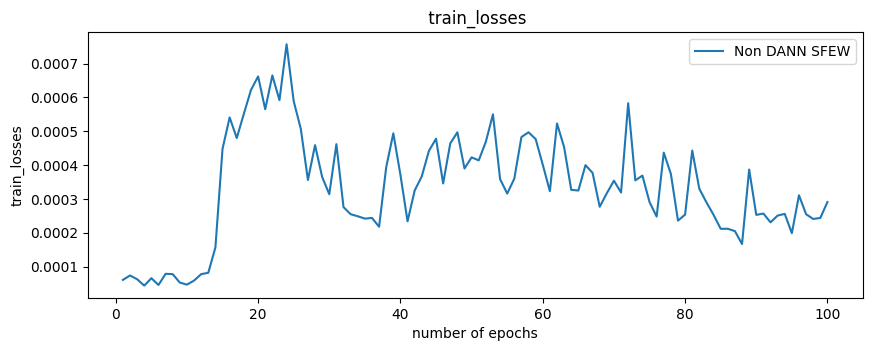

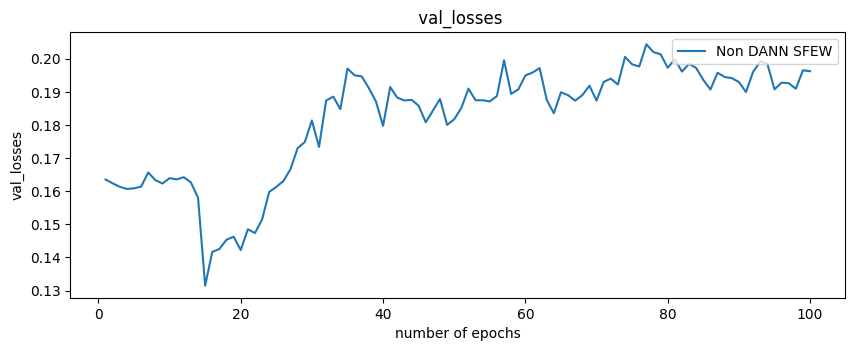

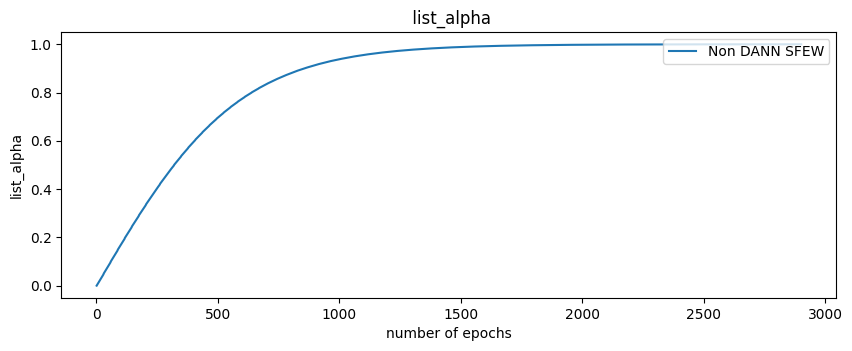

In [31]:
plot_loss_curves(dict_dann_losses,mode='train_losses')
plot_loss_curves(dict_dann_losses,mode='val_losses')
plot_loss_curves(dict_dann_losses,mode='list_alpha')

### Saving DANN Model

In [32]:
model_dann

DANN(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

In [33]:

dann_model_name = "dann_sfew_expw_" + str(time.strftime("%d_%m")) + ".pt"
print(dann_model_name)

# from data_config import DataConfig
dataconfig_1 = DataConfig()
print(dataconfig_1)
MODEL_DIR = dataconfig_1.MODEL_DIR

try:
    DANN_SFEW_EXPW_DIR = Path(dataconfig_1.DANN_SFEW_EXPW_DIR)
except:
    DANN_SFEW_EXPW_DIR =Path(dataconfig_1.MODEL_DIR,"dann_sfew_expw")


if not DANN_SFEW_EXPW_DIR.exists():
    # Create the directory
    DANN_SFEW_EXPW_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {DANN_SFEW_EXPW_DIR} created successfully.')
else:
    print(f'Directory {DANN_SFEW_EXPW_DIR} already exists.')


try:
    torch.save(model_dann.state_dict(), Path(DANN_SFEW_EXPW_DIR,dann_model_name))
    print(f'{dann_model_name} SAVED at {Path(DANN_SFEW_EXPW_DIR,dann_model_name)}!')
except:
    print(f'Problem in saving {dann_model_name}, NOT SAVED!')


dann_sfew_expw_20_01.pt
Directory /content/gdrive/MyDrive/CV_FER/models/dann_sfew_expw already exists.
dann_sfew_expw_20_01.pt SAVED at /content/gdrive/MyDrive/CV_FER/models/dann_sfew_expw/dann_sfew_expw_20_01.pt!


## DANN EWC : Training, Validating, Saving

In [45]:
# dataconfig_inference = DataConfig()

# # NON DANN
# non_dann_model_sfew_name = 'non_dann_sfew_20_01.pt'
# non_dann_model_inference = DANN(num_classes=7) # skeleton copy
# NON_DANN_SFEW_DIR = dataconfig_inference.NON_DANN_SFEW_DIR # Path(self.MODEL_DIR,"non_dann_sfew")

# try:
#     non_dann_model.load_state_dict(torch.load(Path(NON_DANN_SFEW_DIR, non_dann_model_sfew_name),
#                                                         map_location=torch.device(device)))
#     print(f'{non_dann_model_sfew_name} locked and loaded')
# except:
#     print(f' problem in loading {non_dann_model_sfew_name}')


non_dann_sfew_20_01.pt locked and loaded


In [46]:
# model_dann_ewc = non_dann_model # saves training time - check with all


In [47]:
model_dann_ewc

DANN(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

### EWC Code
Regularization Penalty

In [55]:

from torch.autograd import Variable
from torch.autograd import Function

def variable(t: torch.Tensor, use_cuda=True, **kwargs):
    if torch.cuda.is_available() and use_cuda:
        t = t.cuda()
    return Variable(t, **kwargs)

class EWC(object):
    def __init__(self, model: nn.Module,
                 data_loader: torch.utils.data.DataLoader
                #  dataset: list
                 ,device=device
                 , class_loss_function = runconfig.criterion_class):

        self.model = model
        # print("----------MODEL--------\n",self.model)
        self.dataset = data_loader
        self.device = device
        self.class_loss_function = class_loss_function

        # creating dictionary of params which required grad
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}

        self._means = {}
        for n, p in deepcopy(self.params).items():
            self._means[n] = variable(p.data)

        # print("--------self._means----------------\n", self._means)

        self._precision_matrices = self._diag_fisher()

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = variable(p.data)
        # print("--------PRECISION MATRICES----------------\n", precision_matrices)

        self.model.eval()
        for batch in self.dataset:
            self.model.zero_grad()
            images, labels  = variable(batch[0].to(device)), variable(batch[1].to(device))
            class_ouputs, _ , _ = model(images) # class_output, domain_output, features
            task_loss =  self.class_loss_function(class_ouputs,labels)
            task_loss.backward() # only calculating the gradients, not updating it
            # print("--------task loss----------------\n", task_loss)

            for n, p in self.model.named_parameters():
              # if type(p.grad)
              if isinstance(p.grad, type(None)):
                pass # parameter value would remain as it is
              else:
                # print(n,":", type(p.grad))
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

**DANN EWC Object.**

In [56]:
ewc_object = EWC(deepcopy(model_dann_ewc),
                 data_loader=sfew_train_loader,
                 device=device,
                 class_loss_function=runconfig.criterion_class)

### DANN EWC Execution (training and testing) Function without Learning rate


In [57]:

def execute_dann_ewc(model,
                     device,
                     source_train_loader, source_val_loader,
                     target_train_loader, target_val_loader,
                     optimizer,
                     n_epochs, # total number of epochs (different from individual epoch)
                     class_loss_function = nn.CrossEntropyLoss(),
                     domain_loss_function = nn.BCEWithLogitsLoss(),
                     EWC_LAMBDA = 0.4, # to understand regularlization
                     ):

    train_losses = [] # to capture train losses over training epochs
    val_losses = [] # to capture validation loss over epochs
    epoch_converge = n_epochs
    max_batches = min(len(source_train_loader), len(target_train_loader)) # Trying to check which is having less batches.
    existing_model = deepcopy(model)
    model = deepcopy(model).to(device) # copies params from existing model to another one https://discuss.pytorch.org/t/copying-weights-from-one-net-to-another/1492/2
    # model.apply(weights_init) # TODO: skipping weights update - we can experimentation later on, and see if this helps
    list_alpha =[]
    #TODO: Scheduler
    ewc_object = EWC(deepcopy(model),
                     data_loader=source_train_loader,
                     device=device,
                     class_loss_function=class_loss_function) # instantiating EWC object, we would use this object for understanding penalty


    for epoch_idx in range(n_epochs):
        print(f'epoch = {epoch_idx+1}...in EWC DANN execution function')
        source_iterator = iter(source_train_loader)
        target_iterator = iter(target_train_loader)
        epoch_task_loss = 0
        epoch_domain_loss =  0
        epoch_total_loss = 0
        processed = 0

        for batch_idx in range(max_batches-1):
            p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
            alpha = 2. / (1. + np.exp(-10 * p)) - 1
            list_alpha.append(alpha)
            alpha = torch.tensor(alpha)

            model.train() # everytime ?
            optimizer.zero_grad() # flushing out the accumulated gradients

            #---------------------Source Dataset Training ------------------------#
            source_batch = next(source_iterator)
            source_images, source_labels = source_batch[0].to(device), source_batch[1].to(device) # getting images and labels, on device
            source_class_outputs, source_domain_outputs, _ = model(source_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            # Calculating source class loss, regularlized by EWC
            loss_source_class = class_loss_function(source_class_outputs, source_labels) + EWC_LAMBDA * ewc_object.penalty(model)# calculating class loss

            source_domain_inputs = torch.tensor([1., 0.]*len(source_batch[0])).view(-1,2).to(device) # Source Image == [1., 0.]

            loss_source_domain = domain_loss_function(source_domain_outputs, source_domain_inputs) # calculating domain loss

            processed += len(source_batch[0])

            #---------------------Target Dataset Training ------------------------#
            target_batch = next (target_iterator)
            target_images = target_batch[0].to(device) # getting images, on device. There are no labels for target
            _, target_domain_outputs, _ = model(target_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            target_domain_inputs = torch.tensor([0., 1.]*len(source_batch[0])).view(-1,2).to(device) # Target Image == [0., 1.]

            loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)  # calculating domain loss


            #---------------------Combining Loss ------------------------#
            total_loss = loss_source_class + loss_source_domain + loss_target_domain
            total_loss.backward() #backpropogation, creating gradients
            optimizer.step() # updating the params

            epoch_task_loss += loss_source_class.item()
            epoch_domain_loss += loss_source_domain.item() + loss_target_domain.item()
            epoch_total_loss += total_loss.item()

            # after 10 batches
            if (batch_idx % 50 == 0):
                print("Epoch [{}/{}] Step [{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / task_loss={:.4f} / domain_loss={:.4f} / alpha={:.4f}"
              .format(epoch_idx + 1,
                      n_epochs,
                      batch_idx + 1,
                      max_batches,
                      total_loss.item(),
                      loss_target_domain.item()
                      ,loss_source_domain.item()
                      ,loss_source_class.item()
                      ,loss_source_domain.item()+loss_source_class.item(),
                      alpha))
        # After every epoch
        avg_train_task_loss =  float("{:.6f}".format(epoch_task_loss/processed))
        train_losses.append(avg_train_task_loss)

        #TODO: Scheduler

        #Validate Model after every epoch
        correct, avg_val_task_loss = test_model(model= model,
                                                device= device,
                                                data_loader = source_val_loader,
                                                class_loss_function = class_loss_function)
        val_losses.append(avg_val_task_loss)


        #TODO: Early Stopping

    # Testing when the training is over - completed or early stopped
    correct_source, test_loss_source = test_model(model= model,
                            device= device,
                            data_loader = source_val_loader, # source val loader
                            class_loss_function = class_loss_function)

    accuracy_source = correct_source / len(source_val_loader.dataset)

    correct_target, test_loss_target = test_model(model= model,
                            device= device,
                            data_loader = target_val_loader, # target val loader
                            class_loss_function = class_loss_function)

    accuracy_target = correct_target / len(target_val_loader.dataset)


    dict_ewc_dann_losses = {'train_losses' : train_losses,
                        'val_losses': val_losses,
                        'test_loss_source' : test_loss_source,
                        'test_loss_target' : test_loss_target,
                        'epoch_convergence' : 0,
                        'list_alpha' : list_alpha,
                        'test_accuracy_source' : accuracy_source,
                        'test_accuracy_target':accuracy_target  }

    print(f'alpha list \n {list_alpha}')
    return model, dict_ewc_dann_losses





### DANN EWC Execute

In [58]:
runconfig = RunConfig()
lr_ewc_dann = runconfig.inital_lr/5.0 #override
optimizer_ewc_dann = optim.SGD(model_dann.parameters(), lr = lr_ewc_dann, momentum = 0.9)
n_epochs = runconfig.EPOCHS
try:
    EWC_LAMBDA = runconfig.EWC_LAMBDA
except:
    EWC_LAMBDA = 0.4

print(EWC_LAMBDA)

print(f'------------training started for EWC DANN Model ------------------')

ewc_dann_model_sfew_expw , dict_ewc_dann_losses_list_sfew_expw = execute_dann_ewc(model=model_dann,
                                                                                 device=device,
                                                                                 source_train_loader = sfew_train_loader,
                                                                                 source_val_loader = sfew_val_loader,
                                                                                 target_train_loader = expw_train_loader,
                                                                                 target_val_loader = expw_val_loader,
                                                                                 optimizer = optimizer_ewc_dann,
                                                                                 n_epochs = n_epochs,
                                                                                 class_loss_function = runconfig.criterion_class,
                                                                                 domain_loss_function = runconfig.criterion_domain,
                                                                                 EWC_LAMBDA=EWC_LAMBDA, # Hyperparameter about penalty relevance
                                                                                )

0.4
------------training started for EWC DANN Model ------------------
epoch = 1...in EWC DANN execution function
Epoch [1/100] Step [1/30]: loss_total=1.3991 / domain_loss_target=0.6934 / domain_loss_source=0.7039 / task_loss=0.0017 / domain_loss=0.7057 / alpha=0.0000
Test / Val: Average loss: 0.1993, Accuracy: 111/436 (25.46%)

epoch = 2...in EWC DANN execution function
Epoch [2/100] Step [1/30]: loss_total=1.3873 / domain_loss_target=0.7005 / domain_loss_source=0.6847 / task_loss=0.0021 / domain_loss=0.6868 / alpha=0.0500
Test / Val: Average loss: 0.1982, Accuracy: 104/436 (23.85%)

epoch = 3...in EWC DANN execution function
Epoch [3/100] Step [1/30]: loss_total=1.4114 / domain_loss_target=0.6966 / domain_loss_source=0.6984 / task_loss=0.0164 / domain_loss=0.7148 / alpha=0.0997
Test / Val: Average loss: 0.1978, Accuracy: 111/436 (25.46%)

epoch = 4...in EWC DANN execution function
Epoch [4/100] Step [1/30]: loss_total=1.3903 / domain_loss_target=0.6943 / domain_loss_source=0.6922 / 

### DANN EWC Plotting and Validation

In [ ]:
dict_ewc_dann_losses_list_sfew_expw['test_loss_source'], dict_ewc_dann_losses_list_sfew_expw['test_loss_target']

In [ ]:
plot_loss_curves(dict_ewc_dann_losses_list_sfew_expw,mode='train_losses')
plot_loss_curves(dict_ewc_dann_losses_list_sfew_expw,mode='val_losses')
plot_loss_curves(dict_ewc_dann_losses_list_sfew_expw,mode='list_alpha')

### Saving DANN EWC Model

In [ ]:
ewc_dann_model_sfew_expw

In [59]:

ewc_dann_model_name = "ewc_dann_sfew_expw_" + str(time.strftime("%d_%m")) + ".pt"
print(ewc_dann_model_name)

from data_config import DataConfig
dataconfig_2 = DataConfig()
print(dataconfig_2)
MODEL_DIR = dataconfig_2.MODEL_DIR

try:
    EWC_DANN_SFEW_EXPW_DIR = Path(dataconfig_2.EWC_DANN_SFEW_EXPW_DIR)
except:
    EWC_DANN_SFEW_EXPW_DIR =Path(dataconfig_2.MODEL_DIR,"ewc_dann_sfew_expw")


if not EWC_DANN_SFEW_EXPW_DIR.exists():
    # Create the directory
    EWC_DANN_SFEW_EXPW_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {EWC_DANN_SFEW_EXPW_DIR} created successfully.')
else:
    print(f'Directory {EWC_DANN_SFEW_EXPW_DIR} already exists.')

try:
    torch.save(ewc_dann_model_sfew_expw.state_dict(), Path(EWC_DANN_SFEW_EXPW_DIR,ewc_dann_model_name))
    print(f'{ewc_dann_model_name} SAVED at {Path(EWC_DANN_SFEW_EXPW_DIR,ewc_dann_model_name)}!')
except:
    print(f'Problem in saving {ewc_dann_model_name}, NOT SAVED!')


ewc_dann_sfew_expw_20_01.pt
Directory /content/gdrive/MyDrive/CV_FER/models/ewc_dann_sfew_expw already exists.
ewc_dann_sfew_expw_20_01.pt SAVED at /content/gdrive/MyDrive/CV_FER/models/ewc_dann_sfew_expw/ewc_dann_sfew_expw_20_01.pt!
